In [1]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.utils import train_fn
from astra.torch.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
path = "/home/vannsh.jani/brick_kilns/ssl_exp/data"
x_train = torch.load(join(path, "ban_x_train.pt"))
y_train = torch.load(join(path, "ban_y_train.pt"))
x_test = torch.load(join(path, "ban_x_test.pt"))
y_test = torch.load(join(path, "ban_y_test.pt"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_b = torch.cat([x_train, x_test], dim=0).to(device)
y_b = torch.cat([y_train, y_test], dim=0).to(device)

print(x_b.shape, y_b.shape)

torch.Size([19124, 3, 224, 224]) torch.Size([19124]) torch.Size([6375, 3, 224, 224]) torch.Size([6375])
torch.Size([25499, 3, 224, 224]) torch.Size([25499])


In [3]:
x_d = torch.load(join(path, "delhi_test_images_50.pt")).to(device)
y_d = torch.load(join(path, "delhi_test_labels_50.pt"))
print(x_d.shape, y_d.shape)

torch.Size([5013, 3, 224, 224]) torch.Size([5013])


In [4]:
x_d_train = torch.load(join(path, "delhi_5_images.pt")).to(device)
y_d_train = torch.load(join(path, "delhi_5_labels.pt")).long().to(device)
print(x_d_train.shape, y_d_train.shape)

torch.Size([501, 3, 224, 224]) torch.Size([501])


In [5]:
x_b = torch.cat([x_b, x_d_train], dim=0)
y_b = torch.cat([y_b, y_d_train], dim=0)
print(x_b.shape, y_b.shape)

torch.Size([26000, 3, 224, 224]) torch.Size([26000])


In [6]:
# Downstream model
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        eff = torchvision.models.efficientnet_b0(weights=None)
        self.eff = nn.Sequential(*list(eff.children())[:-1])
        self.last_layer = list(eff.children())[-1]
        self.eff.load_state_dict(torch.load("/home/vannsh.jani/brick_kilns/ssl_exp/byol/byol_bd_150.pth"))
        self.last_layer[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.eff(x).squeeze(-2, -1)
        # print(x.shape)
        x = self.last_layer(x)
        return x

In [7]:
model = DownstreamModel(2).to(device)
model(torch.rand(2, 3, 224, 224).to(device)).shape

torch.Size([2, 2])

In [8]:
lr = 1e-4
epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(epochs):
    torch.cuda.empty_cache()
    print("Epoch:", epoch)
    model.train()
    iter_losses, epoch_losses = train_fn(model, loss_fn, x_b, y_b, lr=lr, epochs=1, batch_size=64)
    
    torch.cuda.empty_cache()
    
    model.eval()
    
    with torch.no_grad():
        local_losses = []
        for i in range(0, len(x_b), 64):
            y_pred = model(x_b[i:i+64])
            loss = loss_fn(y_pred, y_b[i:i+64].long())
            local_losses.append(loss.item())

        train_losses.append(sum(local_losses)/len(local_losses))
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        local_losses = []
        local_y_pres = []
        for i in range(0, len(x_d), 128):
            y_pred = model(x_d[i:i+128]).cpu()
            loss = loss_fn(y_pred, y_d[i:i+128].long())
            local_losses.append(loss.item())
            local_y_pres.append(y_pred.argmax(dim=1))
            
        test_loss = sum(local_losses)/len(local_losses)
        test_losses.append(test_loss)
        y_pred = torch.cat(local_y_pres, dim=0)
        print("Accuracy:", accuracy_score(y_d, y_pred))
        print("Precision:", precision_score(y_d, y_pred))
        print("Recall:", recall_score(y_d, y_pred))
        print("F1 Score:", f1_score(y_d, y_pred))
        print("Train Loss:", train_losses[-1])
        print("Test Loss:", test_losses[-1])
        
    torch.cuda.empty_cache()

Epoch: 0


Loss: 0.11318561: 100%|██████████| 1/1 [00:24<00:00, 24.92s/it]


Accuracy: tensor(0.9585)
Precision: tensor(0.8637)
Recall: tensor(0.7666)
F1 Score: tensor(0.8123)
Train Loss: 0.0365619617468547
Test Loss: 0.10499097108840942
Epoch: 1


Loss: 0.03395295: 100%|██████████| 1/1 [00:24<00:00, 24.90s/it]


Accuracy: tensor(0.9565)
Precision: tensor(0.8848)
Recall: tensor(0.7447)
F1 Score: tensor(0.8088)
Train Loss: 0.024573565299061517
Test Loss: 0.11693883212283254
Epoch: 2


Loss: 0.01622165: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9587)
Precision: tensor(0.8407)
Recall: tensor(0.7794)
F1 Score: tensor(0.8089)
Train Loss: 0.009900365303070225
Test Loss: 0.13403520798310636
Epoch: 3


Loss: 0.00641111: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9573)
Precision: tensor(0.8369)
Recall: tensor(0.7717)
F1 Score: tensor(0.8029)
Train Loss: 0.015118572323926386
Test Loss: 0.17347728088498116
Epoch: 4


Loss: 0.00542939: 100%|██████████| 1/1 [00:24<00:00, 24.89s/it]


Accuracy: tensor(0.9629)
Precision: tensor(0.7582)
Recall: tensor(0.8681)
F1 Score: tensor(0.8094)
Train Loss: 0.011939405451157743
Test Loss: 0.18248518677428366
Epoch: 5


Loss: 0.00482321: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9625)
Precision: tensor(0.7620)
Recall: tensor(0.8612)
F1 Score: tensor(0.8086)
Train Loss: 0.008417619994421638
Test Loss: 0.1900272303260863
Epoch: 6


Loss: 0.00487375: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9605)
Precision: tensor(0.7582)
Recall: tensor(0.8458)
F1 Score: tensor(0.7996)
Train Loss: 0.009301807985598237
Test Loss: 0.20584741397760808
Epoch: 7


Loss: 0.00463074: 100%|██████████| 1/1 [00:24<00:00, 24.90s/it]


Accuracy: tensor(0.9553)
Precision: tensor(0.7313)
Recall: tensor(0.8194)
F1 Score: tensor(0.7728)
Train Loss: 0.009620091519468644
Test Loss: 0.22291881646960973
Epoch: 8


Loss: 0.00322095: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9581)
Precision: tensor(0.7524)
Recall: tensor(0.8288)
F1 Score: tensor(0.7887)
Train Loss: 0.008166972436074045
Test Loss: 0.24024268835783005
Epoch: 9


Loss: 0.00343340: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9579)
Precision: tensor(0.8484)
Recall: tensor(0.7700)
F1 Score: tensor(0.8073)
Train Loss: 0.009946441603958182
Test Loss: 0.20149486605077982


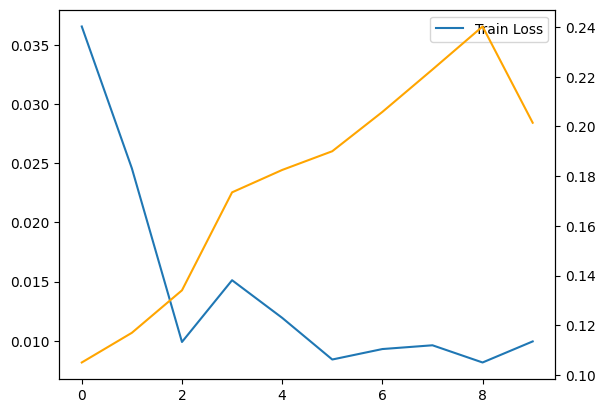

In [9]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.gca().twinx().plot(test_losses, label="Test Loss", color="orange")
# torch.save(model.state_dict(), "byol_lr4_ep50.pth")

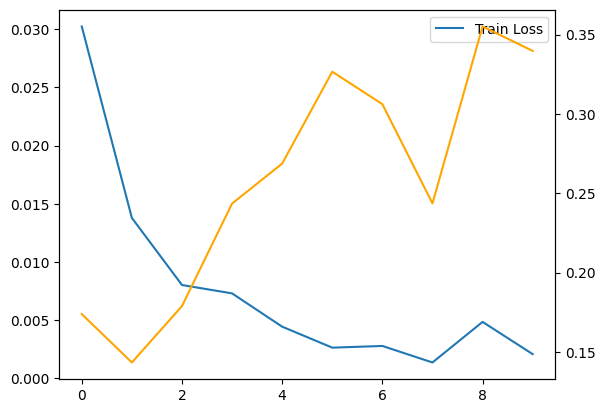